# Tutorial 5

## Stochastic Gradient Descent

Suppose we have an ANN $F_{\theta}$ and a certain loss function $\ell(\theta)$. One update rule has the form
$$
\theta^{(k+1)} \leftarrow \theta^{(k)} - \eta \nabla_{\theta} \, \ell(\theta)\Big|_{\theta = \theta^{(k)}}
$$
with a learning rate $\eta>0$. We use mini-batches of data points to compute the gradient of the loss function $\ell$. Other updates rules often used in the literature:

- ADAM
- AdaGrad
- AdaBoost
- Momentum

## Back-propagation

How to compute the gradient $\nabla_{\theta} \, \ell(\theta)|_{\theta = \theta^{(k)}}$ for general models? For ANNs, back-propagation (backprop) breaks the gradient computations into smaller pieces.

#### Example: Training of a multi-layer neural network

In this example, we perform classification on a dataset from the scikit-learn library.

In [1]:
import numpy as np

import matplotlib.pyplot as plt 

import torch # PyTorch library
import torch.nn as nn # all layers e.g. Recurrent neural network (RNN), etc.
import torch.nn.functional as F # all activation functions
import torch.optim as optim # all optimization procedures, e.g. stochastic gradient descent (SGD), Adam, etc.

from sklearn import datasets # iris dataset

In [2]:
# load the dataset (other examples here: https://scikit-learn.org/stable/datasets/toy_dataset.html)
data = datasets.load_breast_cancer()
features = data.data
labels = data.target
# print(data.DESCR)

# Homework: split the dataset into training/testing

Next, we modify the ANN class we created last week for this classification task.

In [3]:
class MyClassNet(nn.Module):
    # constructor
    def __init__(self, nInputs, nNodes, nLayers, nOutputs):
        super(MyClassNet, self).__init__()
        
        # single input layer
        self.prop_in_to_h = nn.Linear(nInputs, nNodes[0])
        
        # nLayers-1 hidden layers
        self.props_h_to_h = nn.ModuleList([nn.Linear(nNodes[i], nNodes[i+1]) for i in range(nLayers-1)])
        
        # single output layer
        self.prop_h_to_out = nn.Linear(nNodes[-1], nOutputs)

    def forward(self, x):
        
        # input layer with sigmoid as activation function
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        # hidden layers with ReLU as activation function
        for prop in self.props_h_to_h:
            h = torch.relu(prop(h))
        
        # output layer with no activation
        y = torch.softmax(self.prop_h_to_out(h), dim=1)
        
        return y

In [4]:
N_hidden = [16, 32, 32, 16] # number of hidden nodes
N_layers = 4 # number of layers
N_inputs = np.shape(features)[1] # number of features
N_classes = len(np.unique(labels)) # number of classes to predict
seed = 1234

# set random seed
torch.manual_seed(seed) # pytorch
np.random.seed(seed) # numpy

net = MyClassNet(N_inputs, N_hidden, N_layers, N_classes)
net

MyClassNet(
  (prop_in_to_h): Linear(in_features=30, out_features=16, bias=True)
  (props_h_to_h): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (prop_h_to_out): Linear(in_features=16, out_features=2, bias=True)
)

In [5]:
# compute the accuracy (pre-trained)
pred_probs = net(torch.tensor(features, dtype=torch.float))
pred_values = torch.argmax(pred_probs, dim=1).detach().numpy()
np.sum(pred_values == labels) / len(features)

0.6274165202108963

In [6]:
def FitClassNet(net, mini_batch_size, Nepochs):
    
    print(net)
    
    # create  optimizer (instance of gradient descent method)
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    CrossEntropyLoss = nn.CrossEntropyLoss()
    
    # we can customize the loss for our application, i.e.
    # loss_fn = torch.sqrt(torch.mean((outputs - target)**2))
    
    loss_hist = []
    
    for epoch in range(Nepochs):  # loop over the dataset multiple times

        # grab a minibatch
        batch_idx = np.random.choice(len(features), size=mini_batch_size, replace=False)
        features_batch = features[batch_idx]
        labels_batch = labels[batch_idx]

        # the target function
        targets = torch.tensor(labels_batch, dtype=torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()

        # push inputs forward through the whole net
        outputs = net(torch.tensor(features_batch, dtype=torch.float))
        
        # compute the loss associated with this output
        loss = CrossEntropyLoss(outputs, targets)

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )
        
        # print progress every 250 iterations
        if( ( epoch % 250 == 0) and (epoch > 10) ):
            print(epoch)

            
    print(epoch)
    fig, axes = plt.subplots(figsize=(8,5))
    axes.plot(loss_hist)
    axes.set_title('Loss history', fontsize=22)
    axes.set_xlabel('Number of epochs', fontsize=18)
    axes.set_ylabel('Loss', fontsize=18)
    # axes.set_yscale('log')
    axes.tick_params(axis='both', labelsize=16)
    plt.tight_layout(pad=2)
    plt.show()

    print('Finished Training')
    
    return loss_hist, net

MyClassNet(
  (prop_in_to_h): Linear(in_features=30, out_features=16, bias=True)
  (props_h_to_h): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (prop_h_to_out): Linear(in_features=16, out_features=2, bias=True)
)
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
4999


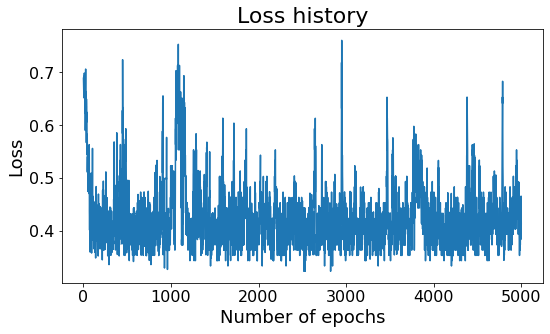

Finished Training


In [7]:
loss_hist, trained_classnet = FitClassNet(net, mini_batch_size=100, Nepochs=5000)

In [8]:
# compute the accuracy (trained net)
pred_probs = trained_classnet(torch.tensor(features, dtype=torch.float))
pred_values = torch.argmax(pred_probs, dim=1).detach().numpy()

In [9]:
np.sum(pred_values == labels) / len(features)

0.8857644991212654